In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import pyLDAvis.gensim_models, pyLDAvis, multiprocessing, gensim, spacy, ast
import warnings, logging, seaborn, shutil, pickle, pprint, time, os, re
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

# TV Commentary: LDA Feature Engineering
#### We use our LDA model to generate features for each player depending on the topics

In [5]:
# Load our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12.csv'

df = pd.read_csv(os.path.join(path, filename)).drop('Mention_Cleaned', axis=1)
df.head(3)

,Player,Year,Race,Mention
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', '..."
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', '..."
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look..."


In [6]:
# Convert our "strange" string format to a coherent text, removing special characters (tag, etc.)
def join_text(text):
    pattern = '^[^a-zA-Z0-9]'
    return ' '.join(token for token in ast.literal_eval(text) if not re.match(pattern, token))

# Convert to list
df['Mention_Cleaned'] = df['Mention'].apply(join_text)
df.head(3)

,Player,Year,Race,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', '...","seen a lot, and weve seen him win a lot that s..."
1,Matt Leinart,2006,White,"['lot', 'that', 's', '<player>', '&gt;&gt;', '...","lot that s and, mike, he has been on top all y..."
2,Matt Leinart,2006,White,"['all', 'you', 'need', 'to', 'do', 'is', 'look...",all you need to do is look at two simple numbe...


In [8]:
### LOAD CHECKPOINT
checkpoint = '__checkpoints'
path = 'commentary-lda_model_overall'
filename_lda = 'lda_model_overall'
filename_corpus = 'commentary-corpus_overall'
filename_data = 'data_overall'
filename_datawords = 'data_words_overall'
filename_dataready = 'data_ready_overall'

# Let's load a checkpoint of our model and corpus
lda_model =  gensim.models.LdaModel.load(os.path.join(checkpoint, path, filename_lda))

with open(os.path.join(checkpoint, filename_corpus + '.pkl'), 'rb') as f:
    corpus = pickle.load(f)

with open(os.path.join(checkpoint, path, filename_data + '.pkl'), 'rb') as f:
    data = pickle.load(f)

with open(os.path.join(checkpoint, path, filename_datawords + '.pkl'), 'rb') as f:
    data_words = pickle.load(f)

with open(os.path.join(checkpoint, path, filename_dataready + '.pkl'), 'rb') as f:
    data_ready = pickle.load(f)

In [9]:
# Add new columns to store the features obtained from the topics
df.insert(3, 'Topic_1',  np.nan)
df.insert(4, 'Topic_2',  np.nan)
df.insert(5, 'Topic_3',  np.nan)
df.insert(6, 'Topic_4',  np.nan)
df.insert(7, 'Topic_5',  np.nan)
df.head(3)

,Player,Year,Race,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,NaN,NaN,NaN,NaN,NaN,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', '...","seen a lot, and weve seen him win a lot that s..."
1,Matt Leinart,2006,White,NaN,NaN,NaN,NaN,NaN,"['lot', 'that', 's', '<player>', '&gt;&gt;', '...","lot that s and, mike, he has been on top all y..."
2,Matt Leinart,2006,White,NaN,NaN,NaN,NaN,NaN,"['all', 'you', 'need', 'to', 'do', 'is', 'look...",all you need to do is look at two simple numbe...


In [10]:
for index, row in df.iterrows():
    topics = lda_model.get_document_topics(corpus[index], minimum_probability=0.0)
    df.at[index, 'Topic_1'] = topics[0][1]
    df.at[index, 'Topic_2'] = topics[1][1]
    df.at[index, 'Topic_3'] = topics[2][1]
    df.at[index, 'Topic_4'] = topics[3][1]
    df.at[index, 'Topic_5'] = topics[4][1]

df.head(5)

,Player,Year,Race,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Mention,Mention_Cleaned
0,Matt Leinart,2006,White,0.066667,0.066667,0.066667,0.066667,0.733330,"['seen', 'a', 'lot,', 'and', 'weve', 'seen', '...","seen a lot, and weve seen him win a lot that s..."
1,Matt Leinart,2006,White,0.050012,0.299917,0.550063,0.050003,0.050004,"['lot', 'that', 's', '<player>', '&gt;&gt;', '...","lot that s and, mike, he has been on top all y..."
2,Matt Leinart,2006,White,0.028589,0.171329,0.600246,0.028584,0.171252,"['all', 'you', 'need', 'to', 'do', 'is', 'look...",all you need to do is look at two simple numbe...
3,Matt Leinart,2006,White,0.020414,0.020453,0.246197,0.692522,0.020414,"['need', 'an', 'offensive', 'line', 'to', 'giv...",need an offensive line to give him an opportun...
4,Matt Leinart,2006,White,0.023937,0.459854,0.278905,0.213137,0.024166,"['get', 'to', 'eavesdrop', 'on', 'this', 'very...",get to eavesdrop on this very tough test again...


In [11]:
# Save our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12_topics.csv'

df.to_csv(os.path.join(path, filename), index=False)

In [12]:
# Load our dataset
path = 'dataset-football_commentary'
filename = 'qb_mentions_12_topics.csv'

df = pd.read_csv(os.path.join(path, filename))

In [13]:
df0 = df[['Race', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']].mean(numeric_only=True)
df1 = pd.DataFrame([[df0[i] for i in range(5)]], columns=['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5'])
df1

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0.210746,0.207389,0.163627,0.200276,0.217962


In [14]:
df2 = df[['Race', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']].groupby('Race').mean().reset_index()
df2

,Race,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,Non-White,0.211170,0.208032,0.162128,0.201810,0.216860
1,White,0.210507,0.207027,0.164470,0.199414,0.218582


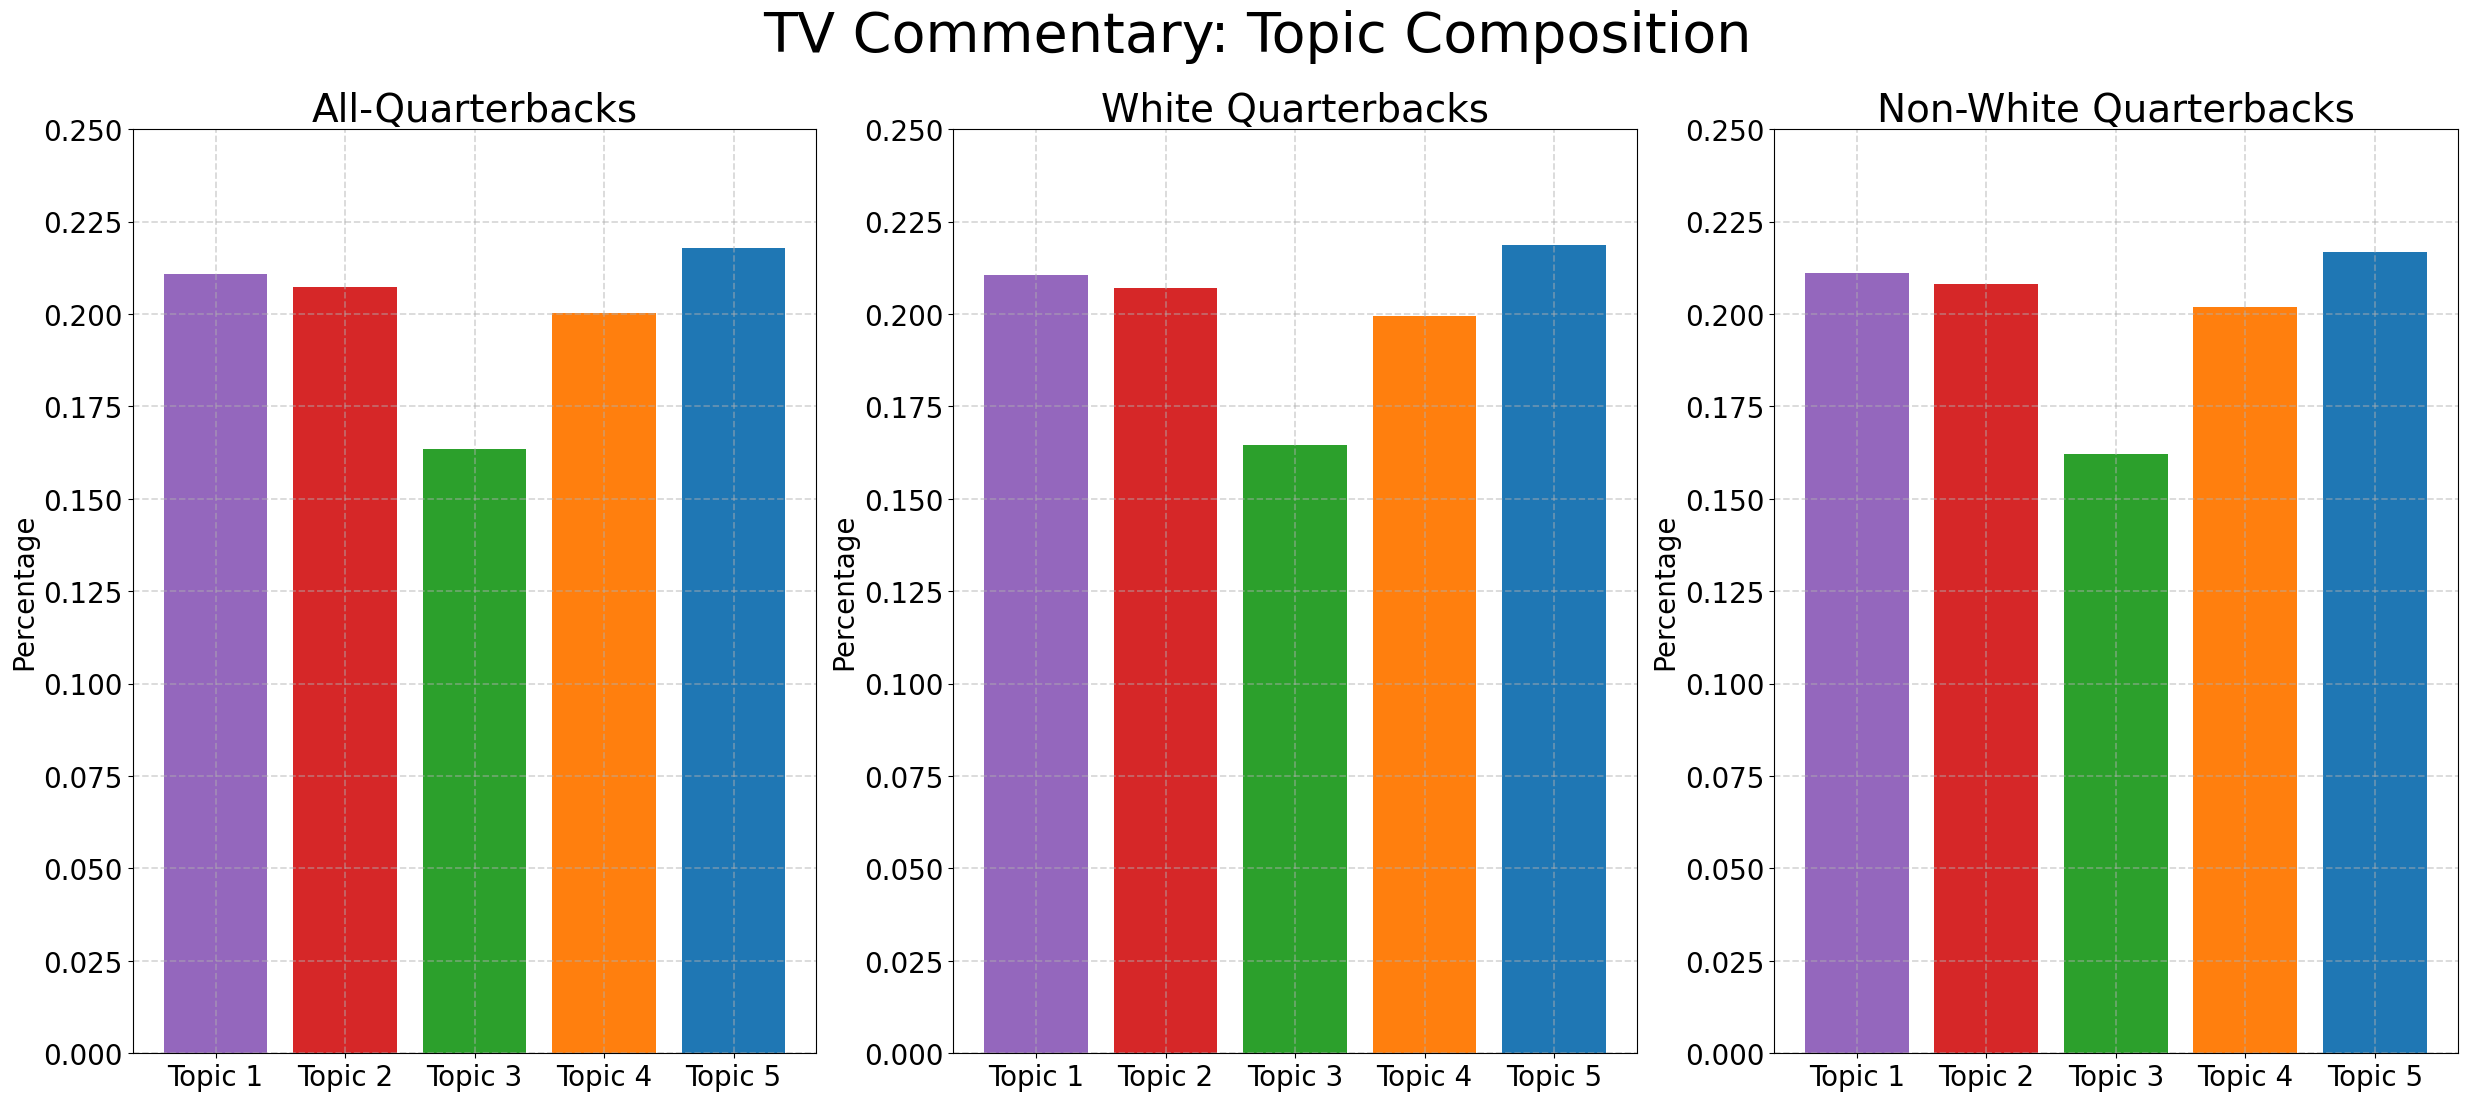

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.26, 0.025)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df1.loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('All-Quarterbacks', fontsize=28)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df2[df2['Race'] == 'White'][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('White Quarterbacks', fontsize=28)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df2[df2['Race'] == 'Non-White'][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title('Non-White Quarterbacks', fontsize=28)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle('TV Commentary: Topic Composition', fontsize=40)
plt.show()

In [19]:
df3 = df[['Race', 'Year', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']]
df3.insert(2, 'Period', '')

for index, row in df3.iterrows():
    if row['Year'] <= 2011:
        df3.at[index, 'Period'] = '2006-2011'
    elif row['Year'] >= 2017:
        df3.at[index, 'Period'] = '2017-2021'
    else:
        df3.at[index, 'Period'] = '2012-2016'

In [20]:
df4 = df3.groupby(['Period']).mean(numeric_only=True).reset_index().drop('Year', axis=1)
df4

,Period,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,2006-2011,0.209631,0.205042,0.162263,0.202763,0.220301
1,2012-2016,0.209934,0.209662,0.164089,0.198495,0.217820
2,2017-2021,0.221148,0.206060,0.167864,0.198027,0.206901


In [21]:
df5 = df3.groupby(['Race', 'Period']).mean().reset_index().sort_values(['Period', 'Race']).reset_index(drop=True).drop('Year', axis=1)
df5

,Race,Period,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,Non-White,2006-2011,0.210859,0.201367,0.162709,0.210435,0.214630
1,White,2006-2011,0.209316,0.205985,0.162149,0.200795,0.221756
2,Non-White,2012-2016,0.210815,0.210867,0.161568,0.198784,0.217967
3,White,2012-2016,0.209116,0.208544,0.166429,0.198228,0.217683
4,Non-White,2017-2021,0.214151,0.205682,0.164322,0.200782,0.215062
5,White,2017-2021,0.226709,0.206361,0.170679,0.195837,0.200414


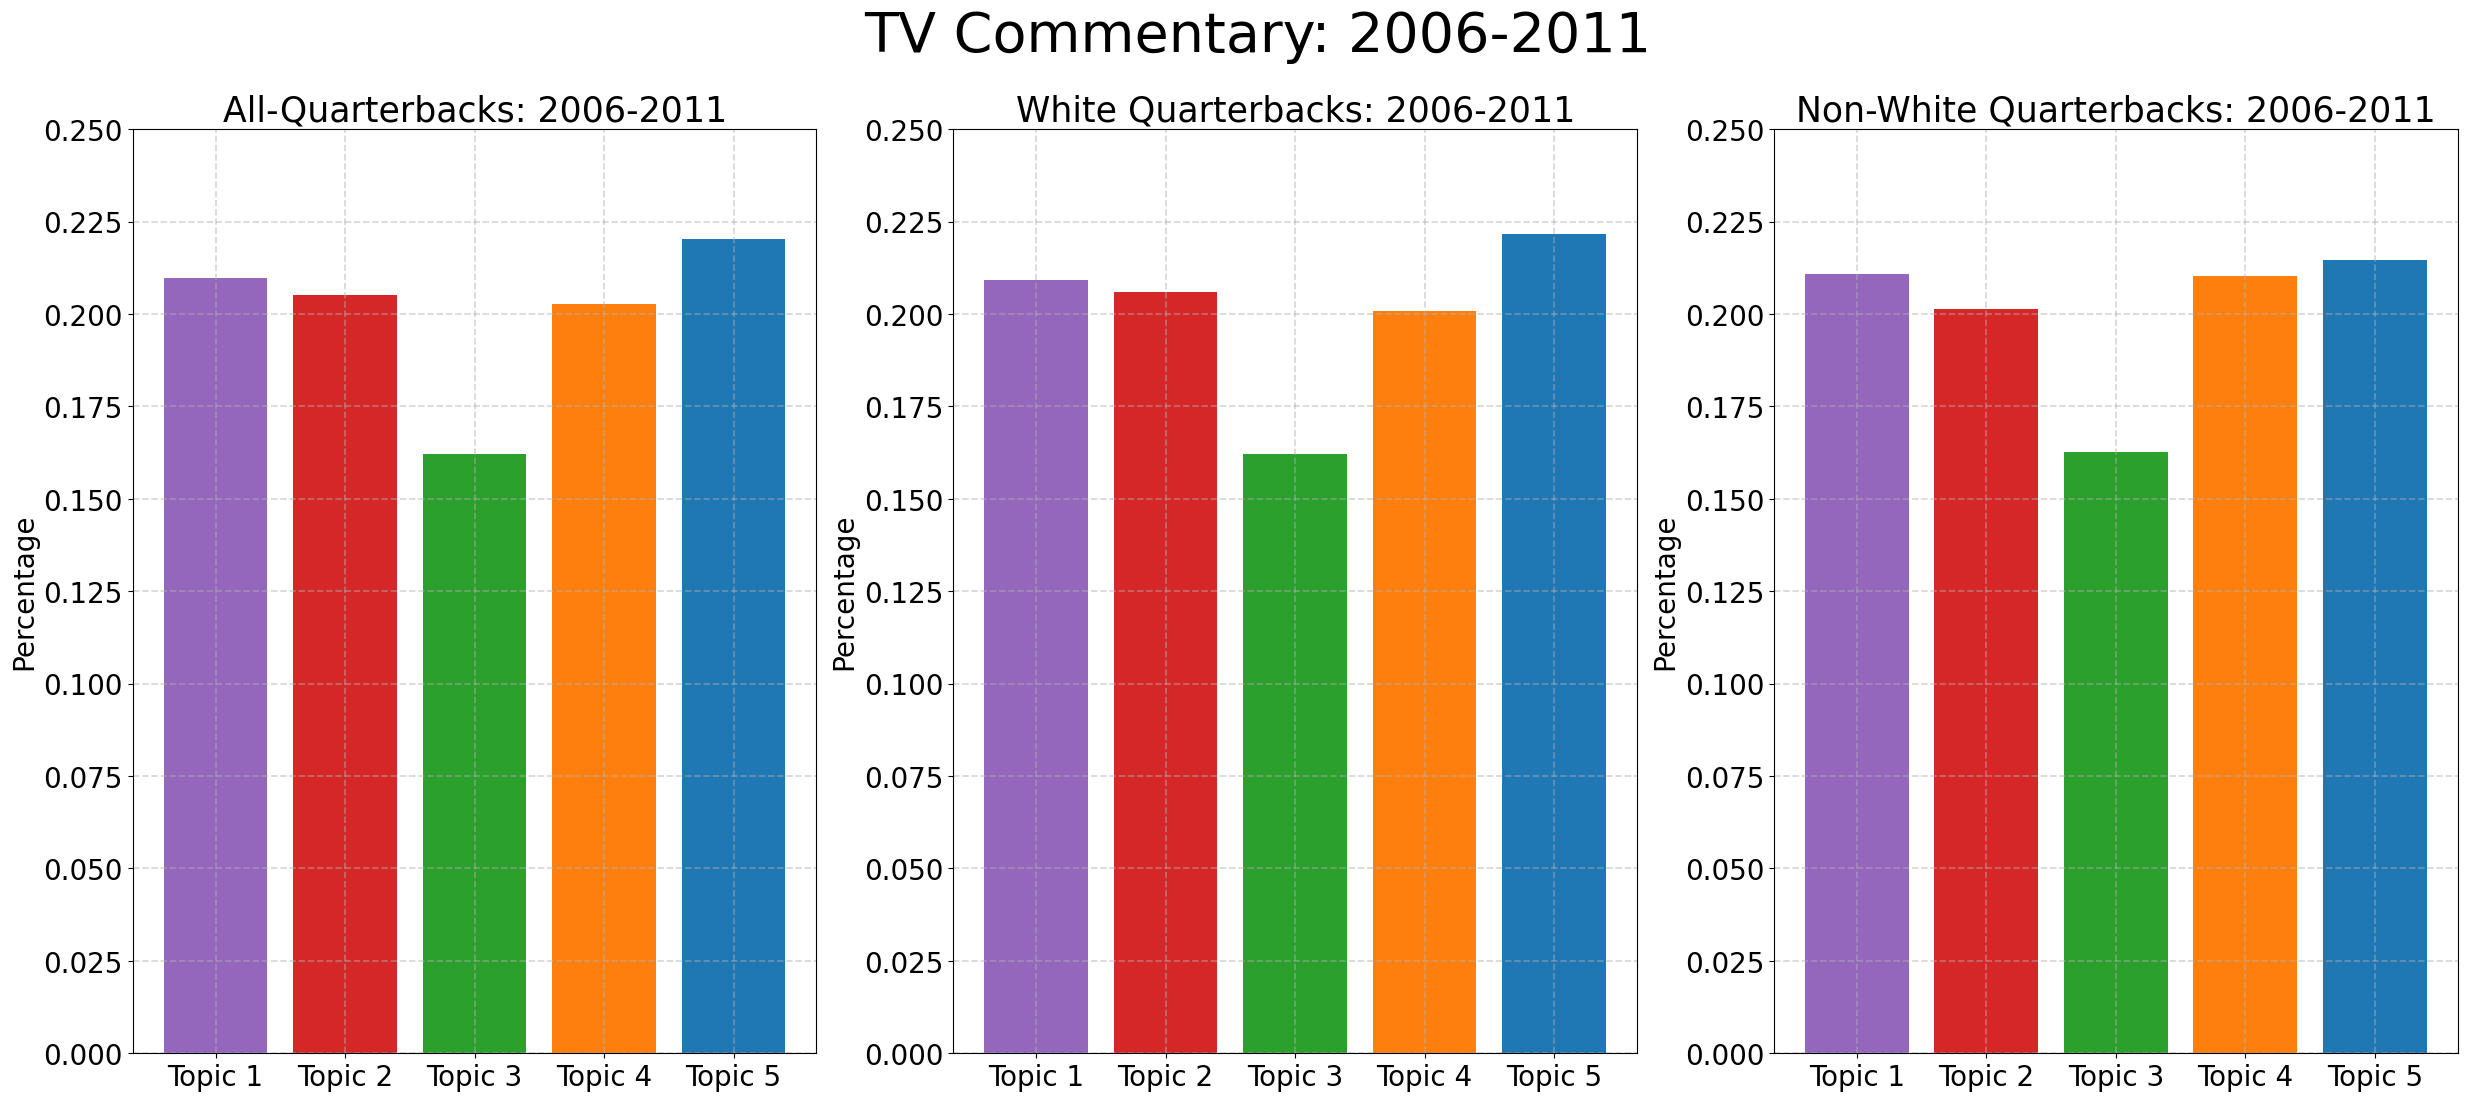

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

period = '2006-2011'
cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.26, 0.025)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df4[df4['Period'] == period][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df5[(df5['Race'] == 'White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df5[(df5['Race'] == 'Non-White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle(f'TV Commentary: {period}', fontsize=40)
plt.show()

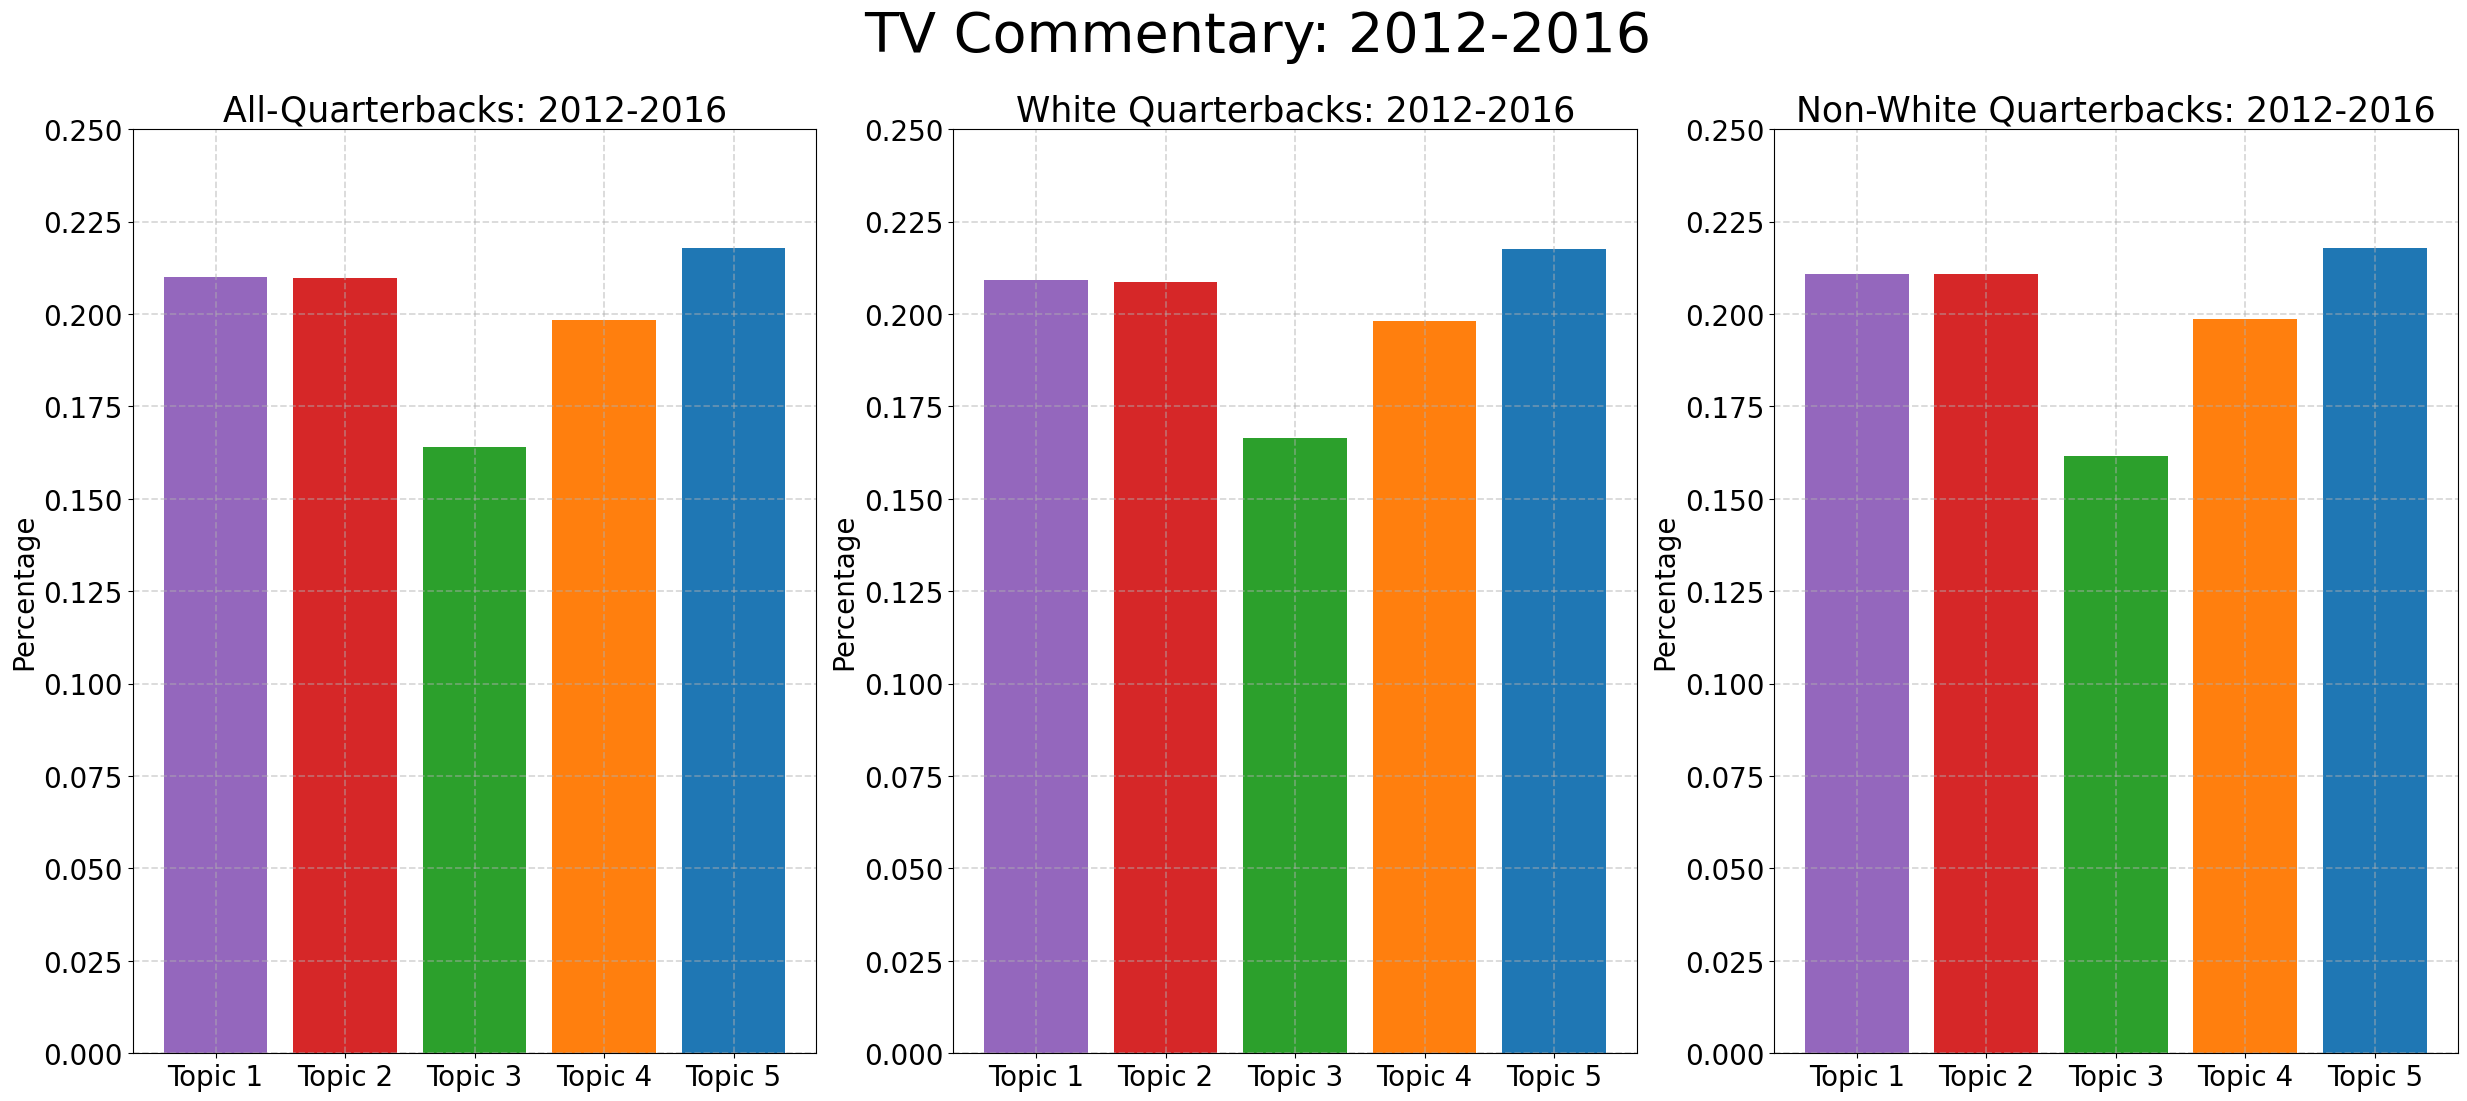

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

period = '2012-2016'
cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.26, 0.025)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df4[df4['Period'] == period][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df5[(df5['Race'] == 'White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df5[(df5['Race'] == 'Non-White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle(f'TV Commentary: {period}', fontsize=40)
plt.show()

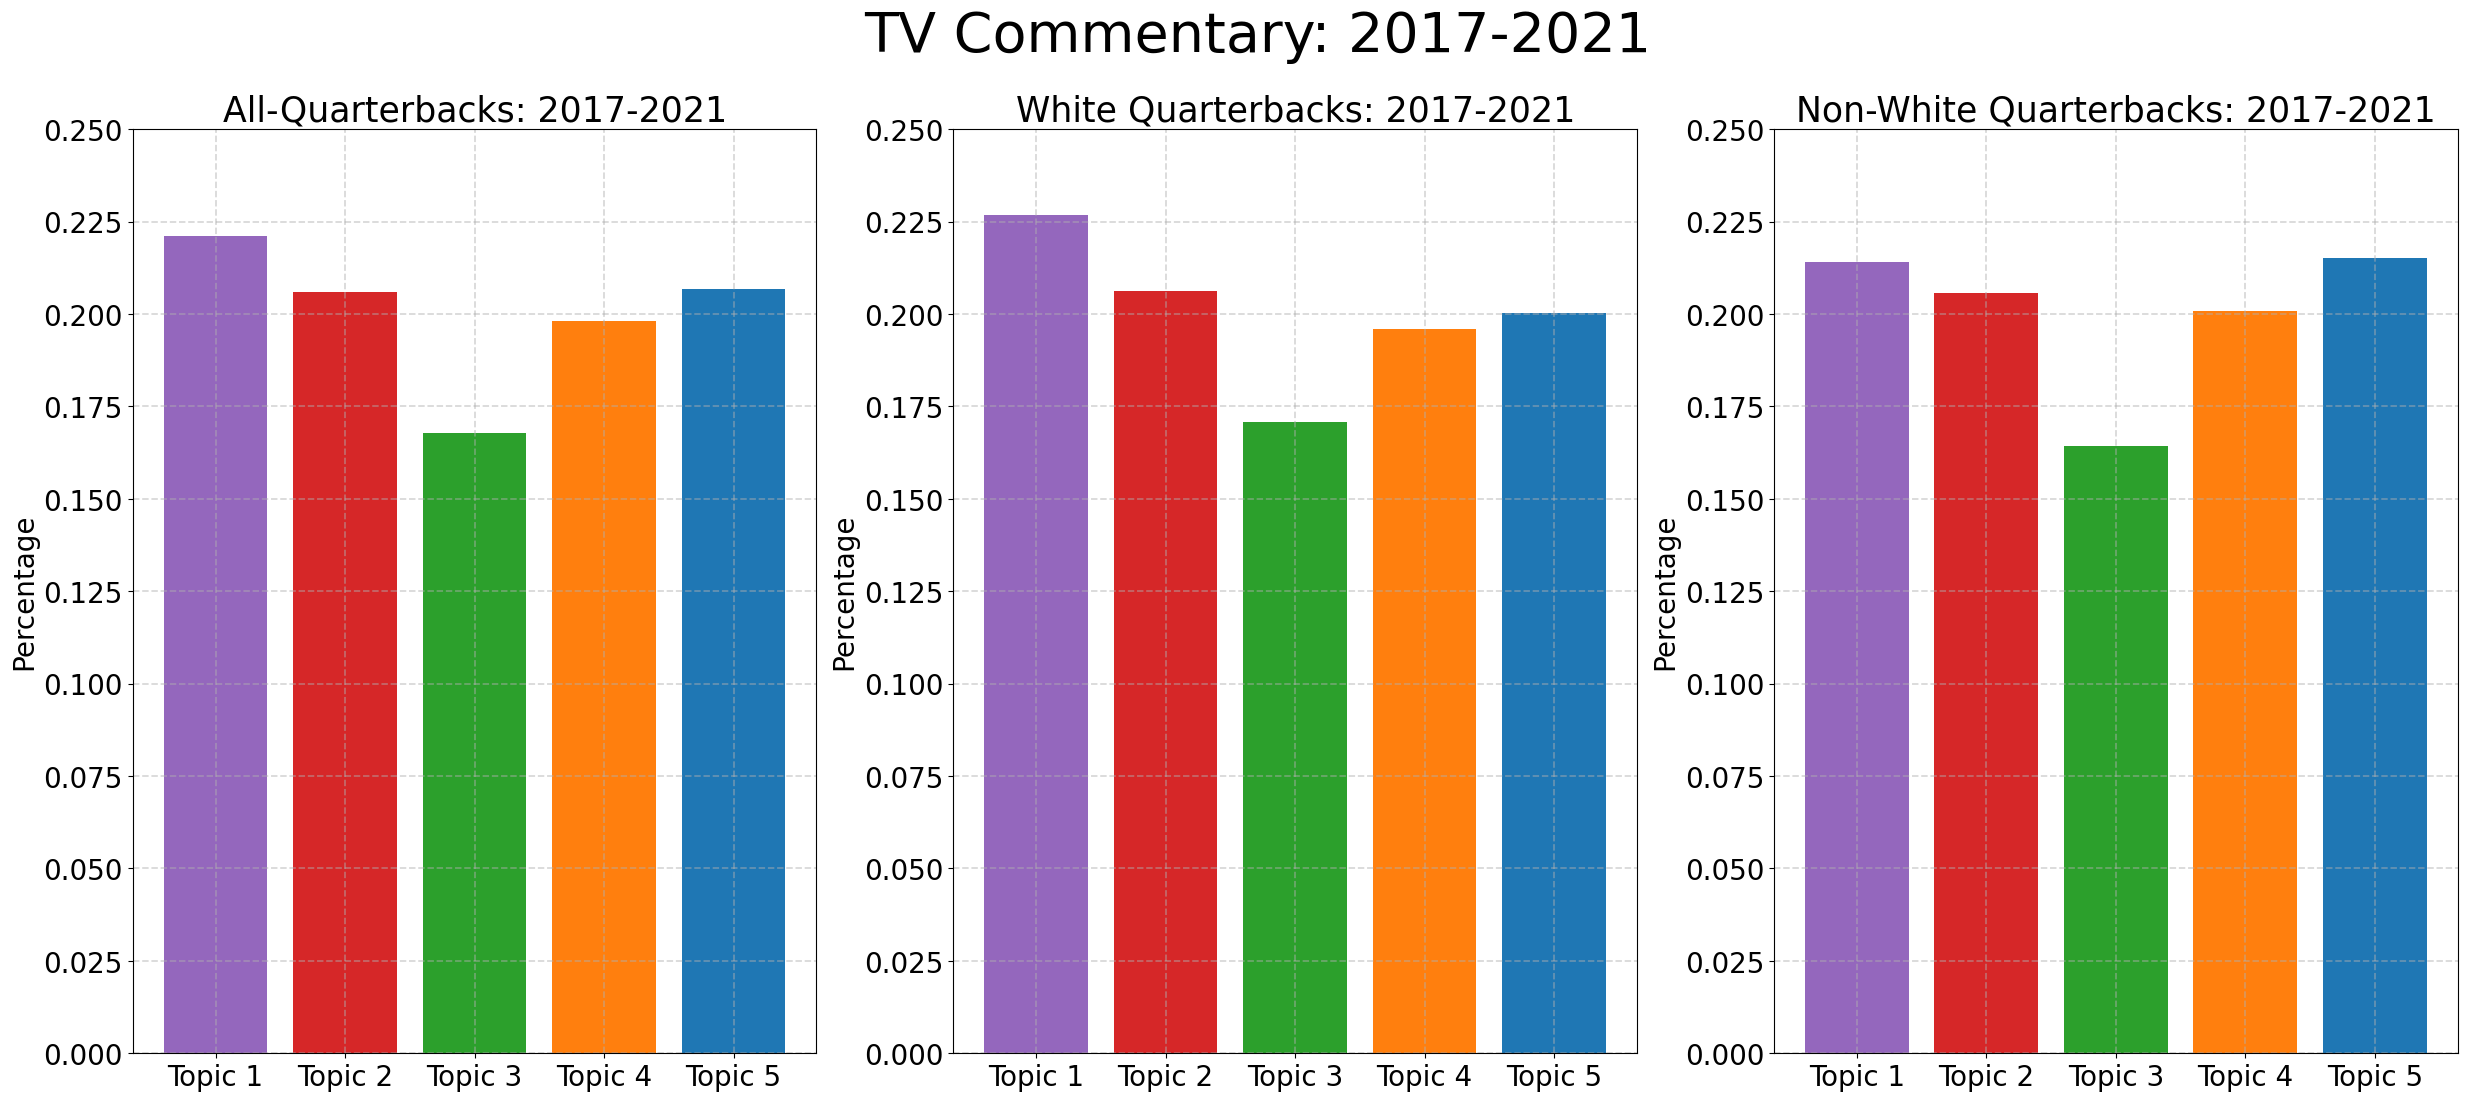

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(30, 12))
plt.rcParams.update({'font.size': 20})

period = '2017-2021'
cols = ['Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5']
x = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
colors = ['tab:purple', 'tab:red', 'tab:green',  'tab:orange', 'tab:blue']
yticks = np.arange(0, 0.26, 0.025)
grid_alpha = 0.5
linestyle = '--'
linewidth = 1.25

ax = axs[0]
y = df4[df4['Period'] == period][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'All-Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[1]
y = df5[(df5['Race'] == 'White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

ax = axs[2]
y = df5[(df5['Race'] == 'Non-White') & (df5['Period'] == period)][cols].reset_index(drop=True).loc[0]
ax.bar(x, y, color=colors)
ax.set(ylabel='Percentage', yticks=yticks)
ax.set_title(f'Non-White Quarterbacks: {period}', fontsize=25)
ax.grid(alpha=grid_alpha, linestyle=linestyle, linewidth=linewidth)

plt.suptitle(f'TV Commentary: {period}', fontsize=40)
plt.show()